In [14]:
import pandas as pd
import altair as alt
import warnings
import matplotlib
warnings.filterwarnings("ignore")
alt.renderers.set_embed_options(theme='light')
pd.set_option("display.max_colwidth", 400)
pd.set_option("display.max_rows", 400)
matplotlib.rcParams['figure.figsize'] = (14.0, 5.0)


Trend line of what yLUNA is being used for?  PRISM Farm, yLUNA Staking, LPing, or Nothing.

In [2]:
prism_addr = 'terra1dh9478k2qvqhqeajhn75a2a7dsnf74y5ukregw'
yluna_addr = 'terra17wkadg0tah554r35x6wvff0y5s7ve8npcjfuhz'
pluna_addr = 'terra1tlgelulz9pdkhls6uglfn5lmxarx7f2gxtdzh2'
pLuna_PRISM_Pair = 'terra1persuahr6f8fm6nyup0xjc7aveaur89nwgs5vs'
yLuna_PRISM_Pair = 'terra1kqc65n5060rtvcgcktsxycdt2a4r67q2zlvhce'
PRISM_cLUNA_Pair = 'terra1yxgq5y6mw30xy9mmvz9mllneddy9jaxndrphvk'
PRISM_UST_Pair = 'terra19d2alknajcngdezrdhq40h6362k92kz23sz62u'
PRISM_xPRISM_Pair = 'terra1czynvm64nslq2xxavzyrrhau09smvana003nrf'
PRISM_LUNA_Pair = 'terra1r38qlqt69lez4nja5h56qwf4drzjpnu8gz04jd'

In [3]:
pool_pairs = [pLuna_PRISM_Pair,yLuna_PRISM_Pair,PRISM_cLUNA_Pair,PRISM_LUNA_Pair,PRISM_UST_Pair,PRISM_xPRISM_Pair]

In [4]:
def claim(claim_hash):
    df = pd.read_json(
            f"https://api.flipsidecrypto.com/api/v2/queries/{claim_hash}/data/latest",
            convert_dates=["BLOCK_TIMESTAMP"])
    df.columns = [c.lower() for c in df.columns]
    return df

In [5]:
def get_url(url):
    return pd.read_csv(url, index_col=0)

In [6]:
class SwapsDataProvider:
    def __init__(self, claim, get_url, path_to_data='../data'):
        self.swaps = '1bfd8019-89a1-470d-8868-60d71e57d1d0'
        self.router = '69b149fb-81ba-4860-aac1-b17f0d6d7688'
        self.claim = claim
        self.get_url = get_url
        self.path_to_data = path_to_data
            
    def load(self):
        self.load_from_url()
        self.load_from_csv()
        self.swaps_df.columns = [c.lower() for c in self.swaps_df.columns]
        self.swaps_df_from_csv.columns = [c.lower() for c in self.swaps_df_from_csv.columns]
        self.router_df_from_csv.columns = [c.lower() for c in self.router_df_from_csv.columns]
        self.router_df.columns = [c.lower() for c in self.router_df.columns]
        self.swaps_df = self.swaps_df.append(self.swaps_df_from_csv).drop_duplicates()
        self.router_df = self.router_df.append(self.router_df_from_csv).drop_duplicates()
            
    def load_from_url(self):
        self.swaps_df = self.claim(self.swaps)
        self.router_df = self.claim(self.router)
        
    def write_to_csv(self):
        self.swaps_df.to_csv(f'{self.path_to_data}/swaps.csv')
        self.router_df.to_csv(f'{self.path_to_data}/router.csv')
        
    def load_from_csv(self):
        self.swaps_df_from_csv = pd.read_csv(f'{self.path_to_data}/swaps.csv', index_col=0)
        self.router_df_from_csv = pd.read_csv(f'{self.path_to_data}/router.csv', index_col=0)
        
    def parse_simple_swaps(self):
        self.swaps_df.columns = [c.lower() for c in self.swaps_df.columns]
        swaps_df = self.swaps_df[self.swaps_df.ask_asset != '']
        swaps_df = swaps_df[swaps_df.sender.notna()]
        swaps_df_pol = swaps_df.rename(columns={'sender':'user','ask_asset':'asset_received','offer_asset':'asset_given'})
        swaps_df_pol = swaps_df_pol[['block_timestamp','tx_id','price','user','asset_received','return_amount','asset_given','offer_amount']]
        swaps_df_pol['operation'] = 'swap'
        self.swaps_df_pol = swaps_df_pol.drop_duplicates(['tx_id','asset_given','asset_received'],ignore_index=True)
        
    def parse_router(self):
        self.router_df.columns = [c.lower() for c in self.router_df.columns]
        router_df = self.router_df.rename(columns={'sender':'user'})
        router_df_1 = router_df[['block_timestamp','tx_id','0_ask_asset','0_offer_amount','0_offer_asset','0_price','0_return_amount','user']]
        router_df_1 = router_df_1.rename(columns={'0_ask_asset':'asset_received','0_offer_amount':'offer_amount',
                           '0_price':'price','0_return_amount':'return_amount','0_offer_asset':'asset_given'})
        router_df_2 = router_df[['block_timestamp','tx_id','1_ask_asset','1_offer_amount','1_offer_asset','1_price','1_return_amount','user']]
        router_df_2 = router_df_2.rename(columns={'1_ask_asset':'asset_received','1_offer_amount':'offer_amount',
                           '1_price':'price','1_return_amount':'return_amount','1_offer_asset':'asset_given'})
        router_df_pol = router_df_1.append(router_df_2)
        router_df_pol['operation'] = 'swap'
        self.router_df_pol = router_df_pol.drop_duplicates(['tx_id','asset_given','asset_received'],ignore_index=True)
    
    def parse(self):
        self.parse_simple_swaps()
        self.parse_router()
        self.swaps_df_all = self.router_df_pol.append(self.swaps_df_pol[self.router_df_pol.columns]).drop_duplicates(['tx_id','asset_given','asset_received'],ignore_index=True)
        self.swaps_df_all.block_timestamp=self.swaps_df_all.block_timestamp.apply(str).apply(lambda x: x[:-4] if len(x) == 23 else x)
        self.swaps_df_all.block_timestamp=self.swaps_df_all.block_timestamp.apply(str).apply(lambda x: x[:-3] if len(x) == 22 else x)
        self.swaps_df_all.block_timestamp=self.swaps_df_all.block_timestamp.apply(str).apply(lambda x: x[:-7] if len(x) == 26 else x)
        self.swaps_df_all['hr'] = self.swaps_df_all.block_timestamp.str[:-5] + '00:00.000'
        self.swaps_df_all['day'] = self.swaps_df_all.block_timestamp.str[:-9]
        #
        yluna_swaps = self.swaps_df_all[(self.swaps_df_all.asset_given=='yLUNA')|(self.swaps_df_all.asset_received=='yLUNA')]
        yluna_swaps['amount_signed'] = yluna_swaps.apply(lambda row: row.offer_amount if row.asset_given == 'yLUNA' else -row.return_amount,axis=1)
        yluna_swaps['type'] = 'swap'
        self.yluna_swaps = yluna_swaps.drop_duplicates(ignore_index=True)
        #
        pluna_swaps = self.swaps_df_all[(self.swaps_df_all.asset_given=='pLUNA')|(self.swaps_df_all.asset_received=='pLUNA')]
        pluna_swaps['amount_signed'] = pluna_swaps.apply(lambda row: row.offer_amount if row.asset_given == 'pLUNA' else -row.return_amount,axis=1)
        pluna_swaps['type'] = 'swap'
        self.pluna_swaps = pluna_swaps.drop_duplicates(ignore_index=True)
        

In [7]:
class LPDataProvider:
    def __init__(self, claim, get_url, path_to_data='../data'):
        self.lp_provide_withdraw = '7f5c7008-648a-4944-9fe9-e6c37e2e7bb8'
        self.claim = claim
        self.get_url = get_url
        self.path_to_data = path_to_data
            
    def load(self):
        self.load_from_url()
        self.load_from_csv()
        self.lp_provide_withdraw_df.columns = [c.lower() for c in self.lp_provide_withdraw_df.columns]
        self.lp_provide_withdraw_df_from_csv.columns = [c.lower() for c in self.lp_provide_withdraw_df_from_csv.columns]
        self.lp_provide_withdraw_df = self.lp_provide_withdraw_df.append(self.lp_provide_withdraw_df_from_csv).drop_duplicates()
            
    def load_from_url(self):
        self.lp_provide_withdraw_df = self.claim(self.lp_provide_withdraw)
        
    def write_to_csv(self):
        self.lp_provide_withdraw_df.to_csv(f'{self.path_to_data}/lp_provide_withdraw.csv')
        
    def load_from_csv(self):
        self.lp_provide_withdraw_df_from_csv = pd.read_csv(f'{self.path_to_data}/lp_provide_withdraw.csv', index_col=0)
        
    def get_action(self, row):
        for i in range(-1,6):
            prefix = f"{i}_" if i >= 0 else ""
            if(f'{prefix}action' in row):
                if(row[f'{prefix}action'] in ['provide_liquidity','withdraw_liquidity']):
                    return row[f'{prefix}action']
                
    def get_n_action(self, row):
        for i in range(-1,6):
            prefix = f"{i}_" if i >= 0 else ""
            if(f'{prefix}action' in row):
                if(row[f'{prefix}action'] in ['provide_liquidity','withdraw_liquidity']):
                    return f'{prefix}'
                
    def correct_parsing(self, row):
        if (row.prefix == '1_' and row.f_action == 'withdraw_liquidity') or \
            (row.prefix == '0_' and row.f_action == 'provide_liquidity'):
            return False
        else:
            return True
                
    def parse(self):
        self.lp_provide_withdraw_df.columns = [c.lower() for c in self.lp_provide_withdraw_df.columns]
        df = self.lp_provide_withdraw_df
        df['f_action'] = df.apply(self.get_action,axis=1)
        df['prefix'] = df.apply(self.get_n_action,axis=1)
        df.block_timestamp=df.block_timestamp.apply(str).apply(lambda x: x[:-4] if len(x) == 23 else x)
        df.block_timestamp=df.block_timestamp.apply(str).apply(lambda x: x[:-3] if len(x) == 22 else x)
        df.block_timestamp=df.block_timestamp.apply(str).apply(lambda x: x[:-7] if len(x) == 26 else x) 
        df['f_contract_address'] = df.apply(lambda row: row[f'{row.prefix}contract_address'], axis=1)
        df['asset'] = df.apply(lambda row: 'yLuna' if row.f_contract_address=='terra1kqc65n5060rtvcgcktsxycdt2a4r67q2zlvhce' \
                                    else 'pLuna', axis=1)
        assert df.apply(self.correct_parsing , axis=1).sum() == 0
        provide_ = df[df.f_action=='provide_liquidity']
        withdraw_ = df[df.f_action=='withdraw_liquidity']
        #
        provide_['prism_amount'] = provide_.apply(lambda row: row['2_amount'] if row['1_contract_address'] == prism_addr else row['3_amount'],axis=1)
        provide_['asset_amount'] = provide_.apply(lambda row: row['1_amount'] if row['2_contract_address'] in [yluna_addr,pluna_addr] else row['2_amount'],axis=1)
        provide_['sender'] = provide_['from_']
        provide_['hr'] = provide_.block_timestamp.str[:-5] + '00:00.000'
        provide_['day'] = provide_.block_timestamp.str[:-9]
        provide_ = provide_[['block_timestamp','sender','tx_id','f_action','prism_amount','asset','asset_amount','hr','day']]
        provide_['amount_signed'] = provide_.asset_amount
        provide_['type'] = 'provide_lp'
        self.provide_ = provide_.drop_duplicates(ignore_index=True).drop_duplicates(['tx_id','asset'],ignore_index=True)
        #
        withdraw_['prism_amount'] = withdraw_.apply(lambda row: row['1_amount'] if row['2_contract_address'] == prism_addr else row['2_amount'],axis=1)
        withdraw_['asset_amount'] = withdraw_.apply(lambda row: row['2_amount'] if row['3_contract_address'] in [yluna_addr,pluna_addr] else row['1_amount'],axis=1)
        withdraw_['sender'] = withdraw_['from_']
        withdraw_['hr'] = withdraw_.block_timestamp.str[:-5] + '00:00.000'
        withdraw_['day'] = withdraw_.block_timestamp.str[:-9]
        withdraw_ = withdraw_[['block_timestamp','sender','tx_id','f_action','prism_amount','asset','asset_amount','hr','day']]
        withdraw_['amount_signed'] = -withdraw_.asset_amount
        withdraw_['type'] = 'withdraw_lp'
        self.withdraw_ = withdraw_.drop_duplicates(ignore_index=True).drop_duplicates(['tx_id','asset'],ignore_index=True)

In [8]:
class DataProvider:
    def __init__(self, asset_name, path_to_data='../data'):
        self.path_to_data = path_to_data
        self.asset_name = asset_name
        self.dates_to_mark = pd.DataFrame([
            ['2022-02-13', '2022-02-13',2000000,'Prism Forge'], 
            ['2022-03-06', '2022-03-06',2400000,'Prism Farm']], 
            columns=['text_date','date','height','text']
        )
    def lp_delta(self, withdraw_, provide_, yluna_swaps, collector_df):
        self.all_lps = withdraw_[['day','amount_signed','tx_id','type','block_timestamp']]\
                            .append(provide_[['day','amount_signed','tx_id','type','block_timestamp']])\
                            .append(yluna_swaps[['day','amount_signed','tx_id','type','block_timestamp']])\
                            .append(collector_df[['day','amount_signed','tx_id','type','block_timestamp']]).drop_duplicates(ignore_index=True)
        daily_delta_lp = self.all_lps.groupby('day').amount_signed.sum().reset_index()
        daily_delta_lp = daily_delta_lp.sort_values(by='day')
        daily_delta_lp['cumsum'] = daily_delta_lp.amount_signed.cumsum().apply(lambda x: round(x,2))
        daily_delta_lp.columns = ['Time', 'Amount signed', 'Amount']
        daily_delta_lp['Type'] = f'{self.asset_name} LP'
        self.daily_delta_lp = daily_delta_lp
        
    def stk_farm_delta(self, ystaking_farm_df):
        daily_delta_stk_farm = ystaking_farm_df.groupby('day').amount_signed.sum().reset_index()
        daily_delta_stk_farm = daily_delta_stk_farm.sort_values(by='day')
        daily_delta_stk_farm['cumsum'] = daily_delta_stk_farm.amount_signed.cumsum().apply(lambda x: round(x,2))
        daily_delta_stk_farm.columns = ['Time', 'Amount signed', 'Amount']
        daily_delta_stk_farm['Type'] = f'{self.asset_name} Farm staked'
        self.daily_delta_stk_farm = daily_delta_stk_farm
        
    def stk_delta(self, ystaking_df):
        daily_delta_stk = ystaking_df.groupby('day').amount_signed.sum().reset_index()
        daily_delta_stk = daily_delta_stk.sort_values(by='day')
        daily_delta_stk['cumsum'] = daily_delta_stk.amount_signed.cumsum().apply(lambda x: round(x,2))
        daily_delta_stk.columns = ['Time', 'Amount signed', 'Amount']
        daily_delta_stk['Type'] = f'{self.asset_name} staked'
        self.daily_delta_stk = daily_delta_stk
        
    def refact_delta(self, all_refreact):
        daily_delta_rf = all_refreact.groupby('day').amount_signed.sum().reset_index()
        daily_delta_rf = daily_delta_rf.sort_values(by='day')
        daily_delta_rf['cumsum'] = daily_delta_rf.amount_signed.cumsum().apply(lambda x: round(x,2))
        daily_delta_rf.columns = ['Time', 'Amount signed', 'Amount']
        daily_delta_rf['Type'] = f'{self.asset_name} circulating'
        self.daily_delta_rf = daily_delta_rf
    
    def unused_asset(self, all_deltas):
        self.asset_used = all_deltas[self.all_deltas.Type.isin([f'{self.asset_name} LP',f'{self.asset_name} staked',f'{self.asset_name} Farm staked'])]
        asset_tot = self.all_deltas[self.all_deltas.Type.isin([f'{self.asset_name} circulating'])]
        asset_unused = self.asset_used.groupby('Time').Amount.sum().rename('Amount_used').reset_index().merge(asset_tot, on='Time')
        asset_unused['Amount_delta'] = asset_unused['Amount'] - asset_unused['Amount_used']
        asset_unused['Amount_delta'] = asset_unused['Amount_delta'].apply(lambda x: x if x>0 else 0)
        asset_unused = asset_unused[['Time','Amount signed','Amount_delta','Type']]
        asset_unused['Type'] = f'{self.asset_name} unused'
        asset_unused.columns = ['Time','Amount signed','Amount','Type']
        self.asset_unused = asset_unused
        
    def all_delta(self):
        self.all_deltas = self.daily_delta_rf.append(self.daily_delta_lp)
        try:
            self.all_deltas = self.all_deltas.append(self.daily_delta_stk)
        except:
            pass
        try:
            self.all_deltas = self.all_deltas.append(self.daily_delta_stk_farm)
        except:
            pass
        
    def fill_date_gaps(self, dff, extra_dates=[]):
        dd = dff.Time.unique()
        dd = [*dd,*extra_dates]
        unique_dates = pd.Series(dd).rename('Time').reset_index().drop(columns='index')
        for t in dff.Type.unique():
            df = dff[dff.Type==t]
            last_date = df.Time.max()
            last_value = df[df.Time==last_date].Amount.values[0]
            df = df.merge(unique_dates, on='Time', how='right')
            df = df[df.Type.isna()]
            if(len(df)>0):
                df['Type'] = t
                df['Amount'] = df.apply(lambda row: last_value if row.Time>last_date else 0,axis=1)
            dff = dff.append(df.fillna(0))
        return dff


In [9]:
swaps_dp = SwapsDataProvider(claim,get_url,'../data')
#swaps_dp.load_from_url()
swaps_dp.load()
swaps_dp.write_to_csv()
swaps_dp.parse()

In [10]:
lp_dp = LPDataProvider(claim,get_url,'../data')
#lp_dp.load_from_url()
lp_dp.load()
lp_dp.write_to_csv()
lp_dp.parse()

# Analysis

In [100]:
df = swaps_dp.swaps_df_all
df = df[(df.day > '2022-03-01')&(df.asset_given=='xPRISM')]

In [101]:
df.columns

Index(['block_timestamp', 'tx_id', 'asset_received', 'offer_amount',
       'asset_given', 'price', 'return_amount', 'user', 'operation', 'hr',
       'day'],
      dtype='object')

[Text(0.5, 1.0, ''), Text(0, 0.5, 'xPRISM')]

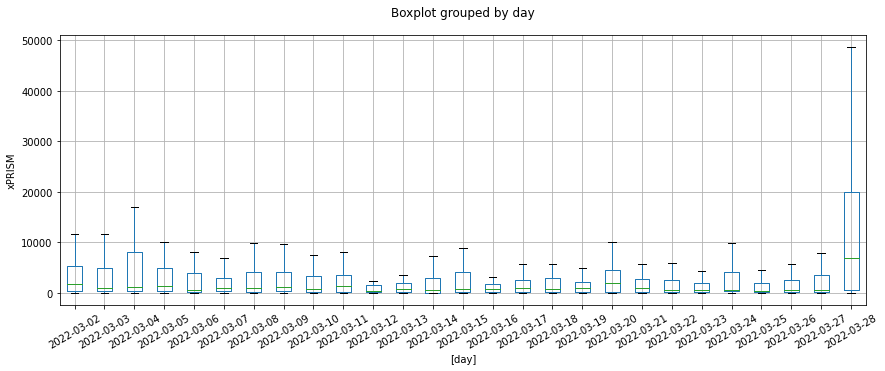

In [102]:
ax = df[['day','offer_amount']].boxplot(by='day', showfliers=False, rot=30)
ax.set(title='', ylabel='xPRISM')

In [103]:
df = df[(df.day == '2022-03-28')&(df.asset_given=='xPRISM')]

In [104]:
df = df.groupby('user').offer_amount.sum().reset_index()
df['user_complete'] = df['user']
df['user'] = df['user'].str[0:10]+'...'+df['user'].str[-10:]

<AxesSubplot:ylabel='user'>

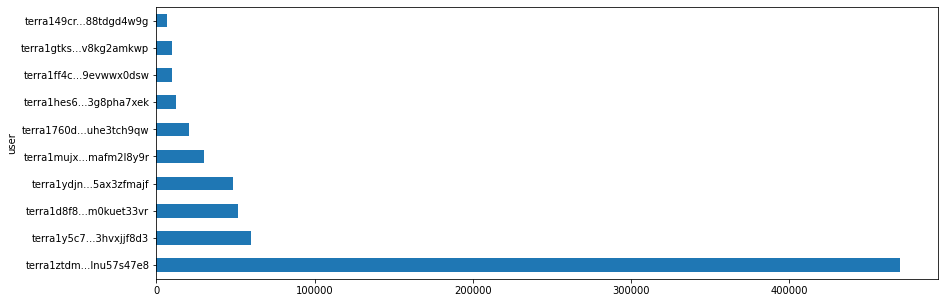

In [105]:
top_sellers = df.sort_values(by='offer_amount', ascending=False)
top_sellers.set_index('user').offer_amount.head(10).plot(kind='barh')

In [106]:
top_sellers = top_sellers.head()

In [112]:
df = swaps_dp.swaps_df_all
df = df[(df.day == '2022-03-28')&(df.user=='terra1jtmpyx3wdpswham92nzatwpwc6h4ulkv2xrdaa')]
df.head()

,block_timestamp,tx_id,asset_received,offer_amount,asset_given,price,return_amount,user,operation,hr,day
79097,2022-03-28 15:15:30,0748FCEB848960ACA8E6AF33B5560A9FCF4EB5544360EE9D5065120AFD17D2DF,NaN,NaN,NaN,NaN,NaN,terra1jtmpyx3wdpswham92nzatwpwc6h4ulkv2xrdaa,swap,2022-03-28 15:00:00.000,2022-03-28
79202,2022-03-28 15:27:20,DBAE46E38325559EA015C43CD3655126E4D3E5E8DBDA4736F668A4B74BAB59C9,NaN,NaN,NaN,NaN,NaN,terra1jtmpyx3wdpswham92nzatwpwc6h4ulkv2xrdaa,swap,2022-03-28 15:00:00.000,2022-03-28
79491,2022-03-28 16:58:12,BDD9A221844B7837578AC7EC7385222AD9FB8F4CD26BB1A7462EDD57C6E34ADD,NaN,NaN,NaN,NaN,NaN,terra1jtmpyx3wdpswham92nzatwpwc6h4ulkv2xrdaa,swap,2022-03-28 16:00:00.000,2022-03-28
80027,2022-03-28 15:48:31,59222FF33F50DB972C8C5872176B03F3F26F0D122F0486FF5B23001B8BAFA601,NaN,NaN,NaN,NaN,NaN,terra1jtmpyx3wdpswham92nzatwpwc6h4ulkv2xrdaa,swap,2022-03-28 15:00:00.000,2022-03-28
80052,2022-03-28 16:17:18,EAB2BAEE1E99107FFCA083FB32D0AE272A36CACDDB7994164C7A02E1B1116089,NaN,NaN,NaN,NaN,NaN,terra1jtmpyx3wdpswham92nzatwpwc6h4ulkv2xrdaa,swap,2022-03-28 16:00:00.000,2022-03-28


In [108]:
amps = pd.read_csv('../data/amps/amps_20220327.csv', index_col=0)

In [113]:
(amps.active_boost.describe()/1000000000).apply(lambda x: format(x, 'f'))

count        0.000006
mean        84.292469
std       1000.612811
min          0.000000
25%          0.014025
50%          2.077265
75%         17.149038
max      61173.645193
Name: active_boost, dtype: object

In [119]:
(amps.active_boost/1000000000).quantile([0.9,0.95,0.99])

0.90      78.836280
0.95     201.043977
0.99    1334.822947
Name: active_boost, dtype: float64

In [110]:
addr_amps = amps[amps.addr.isin(top_sellers.user_complete)][['addr','active_boost']]
addr_amps['active_boost'] = addr_amps['active_boost']/1000000000
addr_amps

,addr,active_boost
175,terra1y5c7zwhlagjvk04mqd54rdw3sdk83hvxjjf8d3,7328.341167
458,terra1mujx82t28as537835qm22a0s0zszmafm2l8y9r,84.849126
262,terra1ztdmjrvjrhgsee3zf3aatjfy3q93lnu57s47e8,9898.686228
517,terra1ydjntynf3zhlv2fwh54cxh37q0qc5ax3zfmajf,0.000000


In [77]:
amps[amps.addr=='terra12j6p3tausehd7495as98vql74p0f9t2ahnafsv'][['active_boost']]/1000000000

,active_boost
968,22.995134


In [114]:
62543584587/1000000000

62.543584587

In [73]:
top_sellers.user_complete

610     terra1jtmp...ulkv2xrdaa
398     terra1cwk4...qd9h5c2qgk
404     terra1d8f8...m0kuet33vr
1095    terra1ztdm...lnu57s47e8
358     terra1as8j...r45chfhqwn
Name: user, dtype: object